# LOBs Encoding 1

This notebook illustrates the LOB encoding with Gaussian Density Filters (GDF).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.stats import norm

import datetime
import time
import pickle
import gzip

% matplotlib inline

import plotly.offline as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
import warnings
py.init_notebook_mode(connected=True)

from ipywidgets import interact, interactive, fixed, interact_manual, widgets

from lobs import *
warnings.filterwarnings('ignore')

In [2]:
filename = "OrderBookSnapshots.csv.9061.zip"
order_book_snapshots = load_order_book_snapshots(filename)
snapshot = order_book_snapshots[131]
date_time, buy_orders, sell_orders = transform_order_book_snapshot_to_orders(snapshot)

## Limit Order Books

In [3]:
@interact(levels=(1, 100))
def _plot_lob_original(levels=15):
    plot_lob(buy_orders, sell_orders, levels, showMidPrice=True, title='Limit Order Book', xtitle='Price', ytitle='Volume')

interactive(children=(IntSlider(value=15, description='levels', min=1), Output()), _dom_classes=('widget-inter…

## Normalization of Limit Order Books

In [35]:
def normalize_limit_order_book(buy_orders, sell_orders):
    bid_prices = buy_orders[:, 0]
    ask_prices = sell_orders[:, 0]
    bid_volumes = buy_orders[:, 1]
    ask_volumes = sell_orders[:, 1]

    bid_volumes = bid_prices * bid_volumes
    ask_volumes = ask_prices * ask_volumes

    total_capital = bid_volumes.sum() + ask_volumes.sum()
    bid_vol_norm = bid_volumes / total_capital
    ask_vol_norm = ask_volumes / total_capital

    min_price = min(bid_prices)
    max_price = max(ask_prices)

    bid_price_norm = (bid_prices - min_price) / (max_price - min_price)
    ask_price_norm = (ask_prices - min_price) / (max_price - min_price)
    buy_orders[:, 1] = bid_vol_norm
    sell_orders[:, 1] = ask_vol_norm
    
    buy_orders[:, 0] = bid_price_norm
    sell_orders[:, 0] = ask_price_norm
    return buy_orders, sell_orders

In [36]:
buy_orders, sell_orders = normalize_limit_order_book(buy_orders, sell_orders)

In [37]:
@interact(levels=(1, 100))
def _plot_lob_normalized(levels=15):
    plot_lob(buy_orders, sell_orders, levels, showMidPrice=True, title='Limit Order Book', xtitle='Price (normalized)', ytitle='Volume (normalized)')

interactive(children=(IntSlider(value=15, description='levels', min=1), Output()), _dom_classes=('widget-inter…

## Encoding Limit Order Books with Gaussian Density Filters

In [38]:
K = 50
gdfs_r = 0.0025 * np.ones(K)
gdfs_m = 0.1000 * np.hstack([np.arange(- K // 2, 0), np.arange(1, K // 2 + 1)])
gdfs_s = 0.0500 * np.ones(K)
gdfs = np.vstack([gdfs_r, gdfs_m, gdfs_s]).T

In [39]:
@interact(levels=(1, 100), gdf=(0, K-1))
def _plot_lob_and_gdf(gdf=K//2+1, levels=20):
    plot_lob_and_gdf(buy_orders, sell_orders, gdfs[gdf, :], levels)
    print('GDF parameters: r = %2.4f, m = %2.4f, s = %2.4f.' % (gdfs[gdf, 0], gdfs[gdf, 1], gdfs[gdf, 2]))
    print('LOB area: %2.4f' % gdf_representation(buy_orders, sell_orders, gdfs[gdf, :]))    

interactive(children=(IntSlider(value=26, description='gdf', max=49), IntSlider(value=20, description='levels'…

In [40]:
@interact(levels=(1, 100), gdf=(0, K-1))
def _plot_lob_clipped_to_gdf(gdf=K//2+1, levels=20):
    plot_lob_clipped_to_gdf(buy_orders, sell_orders, gdfs[gdf, :], levels)
    print('GDF parameters: r = %2.4f, m = %2.4f, s = %2.4f.' % (gdfs[gdf, 0], gdfs[gdf, 1], gdfs[gdf, 2]))
    print('LOB area: %2.4f' % gdf_representation(buy_orders, sell_orders, gdfs[gdf, :]))

interactive(children=(IntSlider(value=26, description='gdf', max=49), IntSlider(value=20, description='levels'…

In [41]:
gdf_features = np.empty(K)
for k in range(K):
    gdf_features[k] = gdf_representation(buy_orders, sell_orders, gdfs[k, :])

plot_gdf_features(gdf_features)

## Adjustement of Parameters of Gaussian Density Filters

In [44]:
@interact(r=(0.01, 1.00, 0.01), s=(0.01, 1.00, 0.01))
def _plot_gdf_features(r=0.01, s=0.05):
    K = 50
    gdfs_r = r * np.ones(K)
    gdfs_m = 0.1000 * np.hstack([np.arange(- K // 2, 0), np.arange(1, K // 2 + 1)])
    gdfs_s = s * np.ones(K)
    gdfs = np.vstack([gdfs_r, gdfs_m, gdfs_s]).T

    gdf_features = np.empty(K)
    for k in range(K):
        gdf_features[k] = gdf_representation(buy_orders, sell_orders, gdfs[k, :])

    plot_gdf_features(gdf_features)

interactive(children=(FloatSlider(value=0.01, description='r', max=1.0, min=0.01, step=0.01), FloatSlider(valu…

## Observing Limit Order Books in Time

In [12]:
N = len(order_book_snapshots)
@interact(t=(0, N-1), levels=(1, 100))
def _plot_lob_original(t=131, levels=15):
    snapshot = order_book_snapshots[t]
    date_time, buy_orders, sell_orders = transform_order_book_snapshot_to_orders(snapshot)

    plot_lob(buy_orders, sell_orders, levels, showMidPrice=True, title='Limit Order Book', xtitle='Price', ytitle='Volume')

interactive(children=(IntSlider(value=131, description='t', max=5473), IntSlider(value=15, description='levels…

In [13]:
@interact(t=(0, N-1), levels=(1, 100))
def _plot_lob_normalized(t=131, levels=15):
    snapshot = order_book_snapshots[t]
    date_time, buy_orders, sell_orders = transform_order_book_snapshot_to_orders(snapshot)
    buy_orders, sell_orders = normalize_limit_order_book(buy_orders, sell_orders)

    plot_lob(buy_orders, sell_orders, levels, showMidPrice=True, title='Limit Order Book', xtitle='Price (normalized)', ytitle='Volume (normalized)')

interactive(children=(IntSlider(value=131, description='t', max=5473), IntSlider(value=15, description='levels…

In [14]:
K = 50
gdfs_r = 0.0025 * np.ones(K)
gdfs_m = 0.1000 * np.hstack([np.arange(- K // 2, 0), np.arange(1, K // 2 + 1)])
gdfs_s = 0.0500 * np.ones(K)
gdfs = np.vstack([gdfs_r, gdfs_m, gdfs_s]).T

In [15]:
@interact(t=(0, N-1))
def _plot_gdf_features(t=131):
    snapshot = order_book_snapshots[t]
    date_time, buy_orders, sell_orders = transform_order_book_snapshot_to_orders(snapshot)
    buy_orders, sell_orders = normalize_limit_order_book(buy_orders, sell_orders)

    gdf_features = np.empty(K)
    for k in range(K):
        gdf_features[k] = gdf_representation(buy_orders, sell_orders, gdfs[k, :])

    plot_gdf_features(gdf_features)

interactive(children=(IntSlider(value=131, description='t', max=5473), Output()), _dom_classes=('widget-intera…

In [16]:
@interact(r=(0.01, 1.00, 0.01), s=(0.01, 1.00, 0.01), t=(0, N-1))
def _plot_gdf_features(r=0.01, s=0.05, t=131):
    K = 50
    gdfs_r = r * np.ones(K)
    gdfs_m = 0.1000 * np.hstack([np.arange(- K // 2, 0), np.arange(1, K // 2 + 1)])
    gdfs_s = s * np.ones(K)
    gdfs = np.vstack([gdfs_r, gdfs_m, gdfs_s]).T
    
    snapshot = order_book_snapshots[t]
    date_time, buy_orders, sell_orders = transform_order_book_snapshot_to_orders(snapshot)
    buy_orders, sell_orders = normalize_limit_order_book(buy_orders, sell_orders)

    gdf_features = np.empty(K)
    for k in range(K):
        gdf_features[k] = gdf_representation(buy_orders, sell_orders, gdfs[k, :])

    plot_gdf_features(gdf_features)

interactive(children=(FloatSlider(value=0.01, description='r', max=1.0, min=0.01, step=0.01), FloatSlider(valu…

In [17]:
@interact(levels=(1, 100),  r=(0.01, 1.00, 0.01), s=(0.01, 1.00, 0.01), t=(0, N-1), gdf=(0, K-1))
def _plot_lob_and_gdf(levels=20, r=0.01, s=0.05, t=131, gdf=K//2+1):
    K = 50
    gdfs_r = r * np.ones(K)
    gdfs_m = 0.1000 * np.hstack([np.arange(- K // 2, 0), np.arange(1, K // 2 + 1)])
    gdfs_s = s * np.ones(K)
    gdfs = np.vstack([gdfs_r, gdfs_m, gdfs_s]).T
    plot_lob_and_gdf(buy_orders, sell_orders, gdfs[gdf, :], levels)
    print('GDF parameters: r = %2.4f, m = %2.4f, s = %2.4f.' % (gdfs[gdf, 0], gdfs[gdf, 1], gdfs[gdf, 2]))
    print('LOB area: %2.4f' % gdf_representation(buy_orders, sell_orders, gdfs[gdf, :]))  

interactive(children=(IntSlider(value=20, description='levels', min=1), FloatSlider(value=0.01, description='r…

In [18]:
@interact(levels=(1, 100),  r=(0.01, 1.00, 0.01), s=(0.01, 1.00, 0.01), t=(0, N-1), K=(1, 50))
def _plot_lob_and_gdf(levels=20, r=0.01, s=0.05, t=131, K=15):
    gdfs_r = r * np.ones(K)
    gdfs_m = 0.1000 * np.hstack([np.arange(- K // 2, 0), np.arange(1, K // 2 + 1)])
    gdfs_s = s * np.ones(K)
    gdfs = np.vstack([gdfs_r, gdfs_m, gdfs_s]).T
    gdf = 1
    plot_lob_and_gdf(buy_orders, sell_orders, gdfs[gdf, :], levels)
    print('GDF parameters: r = %2.4f, m = %2.4f, s = %2.4f.' % (gdfs[gdf, 0], gdfs[gdf, 1], gdfs[gdf, 2]))
    print('LOB area: %2.4f' % gdf_representation(buy_orders, sell_orders, gdfs[gdf, :])) 

interactive(children=(IntSlider(value=20, description='levels', min=1), FloatSlider(value=0.01, description='r…

In [19]:
@interact(r=(0.01, 1.00, 0.01), s=(0.01, 1.00, 0.01), t=(0, N-1), K=(1, 50))
def _plot_gdf_features(r=0.01, s=0.05, t=131, K=15):
    gdfs_r = r * np.ones(K)
    gdfs_m = 0.1000 * np.hstack([np.arange(- K // 2, 0), np.arange(1, K // 2 + 1)])
    gdfs_s = s * np.ones(K)
    gdfs = np.vstack([gdfs_r, gdfs_m, gdfs_s]).T
    
    snapshot = order_book_snapshots[t]
    date_time, buy_orders, sell_orders = transform_order_book_snapshot_to_orders(snapshot)
    buy_orders, sell_orders = normalize_limit_order_book(buy_orders, sell_orders)

    gdf_features = np.empty(K)
    for k in range(K):
        gdf_features[k] = gdf_representation(buy_orders, sell_orders, gdfs[k, :])

    plot_gdf_features(gdf_features)

interactive(children=(FloatSlider(value=0.01, description='r', max=1.0, min=0.01, step=0.01), FloatSlider(valu…

## Random plots

In [20]:
sn = order_book_snapshots[1733]
dt, bo, so = transform_order_book_snapshot_to_orders(sn)
print(dt)
bo, so = normalize_limit_order_book(bo, so)

b = [{'price': b[0], 'volume': b[1]} for b in bo]
df_b = pd.DataFrame(b)
df_b

2013-09-05 09:26:00


,price,volume
0,0.000000,0.000442
1,0.071618,0.002955
2,0.244032,0.001887
3,0.283820,0.008035
4,0.286472,0.000978
5,0.289125,0.001267
6,0.297082,0.008149
7,0.307692,0.001349
8,0.310345,0.004701
9,0.315650,0.004336


In [21]:
K = 50
gdfs_r = 0.0025 * np.ones(K)
gdfs_m = 0.1000 * np.hstack([np.arange(- K // 2, 0), np.arange(1, K // 2 + 1)])
gdfs_s = 0.0500 * np.ones(K)
gdfs = np.vstack([gdfs_r, gdfs_m, gdfs_s]).T

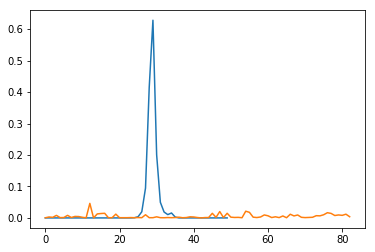

In [22]:
plt.plot([gdf_representation(bo, so, gdfs[k, :]) for k in range(0, K)])
plt.plot(df_b[[ 'volume']])

In [23]:
gdf_representation(bo, so, gdfs[0, :])

0.0

In [24]:
dt

datetime.datetime(2013, 9, 5, 9, 26)

In [25]:
buy_orders

array([[0.00000000e+00, 3.16358218e-03],
       [2.28571429e-01, 8.55029441e-03],
       [2.31428571e-01, 1.04481906e-03],
       [2.34285714e-01, 1.35607607e-03],
       [2.42857143e-01, 8.72375727e-03],
       [2.54285714e-01, 1.44386679e-03],
       [2.57142857e-01, 4.62760435e-03],
       [2.62857143e-01, 4.64206562e-03],
       [2.71428571e-01, 1.74890907e-03],
       [2.85714286e-01, 4.02764720e-02],
       [2.88857143e-01, 8.82724569e-04],
       [2.94571429e-01, 8.85436056e-04],
       [3.00285714e-01, 8.88147543e-04],
       [3.06000000e-01, 8.90859030e-04],
       [3.11714286e-01, 8.93570517e-04],
       [3.14285714e-01, 7.22215389e-03],
       [3.15142857e-01, 9.11310962e-04],
       [3.17428571e-01, 8.96282004e-04],
       [3.18857143e-01, 1.19594650e-03],
       [3.20000000e-01, 1.49583695e-02],
       [3.23142857e-01, 8.98993490e-04],
       [3.28571429e-01, 1.57474122e-02],
       [3.28857143e-01, 9.01704977e-04],
       [3.34571429e-01, 9.04416464e-04],
       [3.371428

In [26]:
@interact(levels=(1, 100),  r=(0.01, 1.00, 0.01), s=(0.01, 1.00, 0.01), m=(0.001, 1.00, 0.01), t=(0, N-1), K=(1, 50))
def _plot_lob_and_gdf(levels=20, r=0.01, s=0.05, m=0.1, t=131, K=15):
    gdfs_r = r * np.ones(K)
    gdfs_m = m * np.hstack([np.arange(- K // 2, 0), np.arange(1, K // 2 + 1)])
    gdfs_s = s * np.ones(K)
    gdfs = np.vstack([gdfs_r, gdfs_m, gdfs_s]).T
    gdf = 1
    plot_lob_and_gdf(buy_orders, sell_orders, gdfs[gdf, :], levels)
    print('GDF parameters: r = %2.4f, m = %2.4f, s = %2.4f.' % (gdfs[gdf, 0], gdfs[gdf, 1], gdfs[gdf, 2]))
    print('LOB area: %2.4f' % gdf_representation(buy_orders, sell_orders, gdfs[gdf, :])) 

interactive(children=(IntSlider(value=20, description='levels', min=1), FloatSlider(value=0.01, description='r…